# Task 3.1 : A Memory Efficient Voted Perceptron

Freund & Schapire (1999) introduced the voted-perceptron algorithm, which scales
the contribution to its weight vectors by a factor depending on how many correct classifications it
has taken part in during training. They also demonstrated that despite its simplicity, the algorithm
can be competitive with significantly more involved algorithms such as the support vector machine.
However, a major drawback is that it has a memory complexity of O(k), where k is the number of
times a sample is misclassified during training.

**Data:** $ \mathcal{D} := \{ (\mathbf{x_1}, y_1),...,(\mathbf{x_n}, y_n) \} $<br>
**Result:** $\upsilon := \{(\mathbf{w_1}, c_1 ), . . . , (\mathbf{w_k}, c_k)\}$<br>
$\mathbf{w_1} := 0^d;$<br>
$c_1 := 1;$<br>
$k := 1;$<br>
**while** *not converged* **do**<br>
    $\hspace{0.5cm}$ **for** $i := 1,..,n$ **do**<br>
    $ \hspace{1.0cm} \hat{y} = 
        \begin{cases}
        1 & \mathbf{w_k} \cdot \mathbf{x_i} \geq 0  \\
        0 & \text{otherwise}
        \end{cases}$<br>
        $\hspace{1.0cm}$ **if** $\hat{y} = y$ **then**<br>
            $\hspace{1.5cm} c_k := c_k + 1;$<br>
        $\hspace{1.0cm}$**else**<br>
            $\hspace{1.5cm}\mathbf{w_{k+1}} := \mathbf{w_k} + (y - \hat{y})\mathbf{x_i};$<br>
            $\hspace{1.5cm}c_{k+1} := 1;$<br>
            $\hspace{1.5cm}k := k + 1;$<br>
        $\hspace{1.0cm}$**end**<br>
    $\hspace{0.5cm}$**end**<br>
**end**

**Algorithm 1:** The voted-perceptron training algorithm with bias terms omitted.

Once trained, the algorithm performs predictions as follows:

>$$ f(\mathbf{x}) = 
\begin{cases}
1 &  [\sum_{i:=1}^k c_i(\mathbf{w_i} . \mathbf{x})] \geq 0 \\
0 & \text{otherwise}
\end{cases}$$

In [ ]:
#Extract dataset
!bash setup/download.sh

## Importing Libraries

In [1]:
#Importing libraries
import numpy as np
from matplotlib import pyplot as plt
import helpers

## Tasks: 

1. Derive a variant of the voted perceptron with memory complexity O(1) – informally, that the memory usage remains constant regardless of the number of updates.

Our proposed variant of the voted perceptron algorithm is as follows:

**Data:** $ \mathcal{D} := \{(\mathbf{x_1}, y_1),...,(\mathbf{x_n}, y_n)\} $<br>
**Result:** $\upsilon := 0 $<br>
$\mathbf{w} := 0^d;$<br>
$c := 1;$<br>
**while** *not converged* **do**<br>
    $\hspace{0.5cm}$ **for** $i := 1,..,n$ **do**<br>
    $ \hspace{1.0cm} \hat{y_i} = 
        \begin{cases}
        1 & \mathbf{w} \cdot x_i \geq 0  \\
        0 & \text{otherwise}
        \end{cases}$<br>
        $\hspace{1.0cm}$ **if** $\hat{y_i} = y_i$ **then**<br>
            $\hspace{1.5cm} c := c + 1;$<br>
        $\hspace{1.0cm}$**else**<br>
            $\hspace{1.5cm}\upsilon = \upsilon + c\mathbf{w}$<br>
            $\hspace{1.5cm}\mathbf{w} := \mathbf{w} + (y_i - \hat{y_i})\mathbf{x_i};$<br>
            $\hspace{1.5cm}c := 1;$<br>
        $\hspace{1.0cm}$**end**<br>
    $\hspace{0.5cm}$**end**<br>
**end**

Our prediction function can now be represented as follows:

>$$ f(x) = 
\begin{cases}
1 & \upsilon \cdot \mathbf{x} \geq 0 \\
0 & \text{otherwise}
\end{cases}$$

2. Prove that your efficient variant is functionally equivalent to the voted perceptron.

3. Implement your efficient variant in your Colaboratory notebook.

In [2]:
#Helper functions
def predict(images, v):
    """
    Predicts classes on a set of images.
    
    Args
    ----
    images : Flattened image data. Should be NumPy array of shape (# images, # pixels)
    v : Trained weights. Should be NumPy array of shape (# pixels, )
    
    Returns
    -------
    pred : Class predictions. Should be NumPy array of shape (#images, )
    """
    
    pred = np.where(images @ v >= 0, 1.0, 0.0)
    return pred

def accuracy(images, labels, v):
    """
    Computes accuracy of trained model.
    
    Args
    ----
    images : Flattened image data. Should be NumPy array of shape (# images, # pixels)
    labels : Labels corresponding to image data. Should be NumPy array of shape (# images, )
    v : Trained weights. Should be NumPy array of shape (# pixels, )
    
    Returns
    -------
    accuracy : Scalar value representing accuracy of predictions.
    """
    
    #Predict on dataset
    predictions = predict(images, v)
    
    #Check how many are correct
    correct = np.sum(np.where(predictions == labels, 1.0, 0.0))
    accuracy = correct/len(images)
    return accuracy

def shuffle_data(X, y):
    """
    Returns a shuffled copy of data from original data.
    
    Args
    ----
    X = NumPy array of images, shape (# images, #pixels)
    Y = NumPy array of labels, shape (# images, )
    
    Returns
    -------
    Tuple of shuffled data (X, y)
    """
    
    nData = X.shape[0]
    perm = np.random.permutation(nData)
    X = X[perm, :]
    y = y[perm]
    return(X, y)

In [3]:
def vp_modified(data, epochs=100, epsilon=0.005, tolerance=3, shuffle=True, seed=1):
    """
    Implementation of modified voted perceptron algorithm with memory complexity O(1).
    
    Args
    ----
    data : tuple of training and validation data (x_train, y_train, x_val, y_val)
    epochs : number of epochs to train over. *Note this is the max number of epochs the model will train for. Training could end earlier if convergence is achieved.
    epsilon : Hyperparameter for convergence criteria. For convergence to occur, the difference in training accuracy between current and previous epoch must be < epsilon. 
    tolerance : number of epochs over which we allow for this small difference to persist.
    shuffle : Set to true in order to shuffle the training examples.
    seed : Ensures reproducible results.
    
    Returns
    -------
    v : NumPy array of shape (# pixels, )
    train_accuracy_values : List of training accuracy values for each epoch of training.
    val_accuracy_values : List of validation accuracy values over each epoch of training.
    """
    
    np.random.seed(seed)
    
    #Extract data
    x_train, y_train, x_val, y_val = data
    
    n_data = x_train.shape[0]
    n_dim = x_train.shape[1]
    
    #Initialize v, c, w
    v = np.zeros((n_dim, ))
    w = np.zeros((n_dim, ))
    c = 1
    
    #This will store accuracy values after each epoch
    train_accuracy_values = []
    val_accuracy_values = []

    #This will store the number of epochs over which accuracy difference was less than epsilon
    k = 0
    
    for epoch in range(epochs):
        
        print("Epoch {}".format(epoch+1))
        
        #Record accuracy pre-epoch
        train_accuracy_old = accuracy(x_train, y_train, v)
        #print(">> Accuracy pre-epoch = {}".format(train_accuracy_old))
        
        if shuffle:
            x_train_shuffled, y_train_shuffled = shuffle_data(x_train, y_train)
        else:
            x_train_shuffled, y_train_shuffled = x_train, y_train
        
        #Iterate over training examples
        for i in range(n_data):
            y_hat = 1.0 if np.dot(w, x_train_shuffled[i]) >= 0.0 else 0.0
            
            #Update c if the true class and predicted class are equal
            if y_hat == y_train_shuffled[i]:
                c += 1
                
            #Perform v, w, c update if misclassified
            else:
                v += c*w
                w += (y_train_shuffled[i] - y_hat)*x_train_shuffled[i]
                c = 1
        
        #Record accuracy on training set and check difference relative to previous epoch
        train_accuracy_new = accuracy(x_train, y_train, v)
        difference = train_accuracy_new - train_accuracy_old
        
        train_accuracy_values.append(train_accuracy_new)
        print(">> Training accuracy = {}".format(train_accuracy_new))
        print(">> Difference compared to previous epoch = {}".format(difference))
        
        #Record accuracy on validation set
        val_accuracy = accuracy(x_val, y_val, v)
        val_accuracy_values.append(val_accuracy)        
        print(">> Validation accuracy = {}".format(val_accuracy))
        
        
        #EARLY STOPPING CRITERIA:
        
        #If the difference in accuracy is lesser than epsilon and this occurs over lesser than 3 epochs, then add 1 to k
        if (np.abs(difference) <= epsilon and k < tolerance):
            k += 1
            
        #If the difference is lesser than epsilon but k=3, then we have converged and can end training.
        if (np.abs(difference) <= epsilon and k == tolerance):
            print("Minimal change in training accuracy. Training completed early.")
            break
            
        #Suppose we saw a small difference over atleast 1 (but < 5) consecutive epochs but then suddenly a large jump in accuracy occurs, then we want to reset k=0 and restart the counting.
        #Note that if we saw a large difference and k = 0, that's just the same as going into the while loop and running another epoch again.
        if (np.abs(difference) > epsilon and k >= 1):
            k = 0

    return v, train_accuracy_values, val_accuracy_values

4. Train your model to convergence on the training set.

In [4]:
#Load the training data
train_img, train_labels = helpers.get_data("../data/", data_type="train")

#Load the validation data - we will use it in the last question
val_img, val_labels = helpers.get_data("../data/", data_type="dev")

Number of training images : 12000
Labels : [0 1]


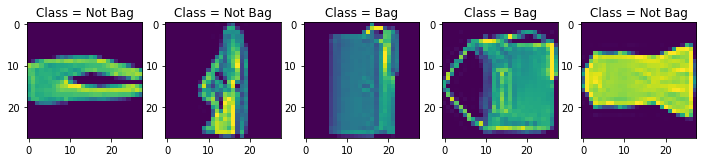

In [5]:
n = train_img.shape[-1]
classes = ['Not Bag', 'Bag']

print("Number of training images : {}".format(n))
print("Labels : {}".format(np.unique(train_labels)))

plt.figure(figsize=(12,6))
#Visualizing a few images and corresponding labels
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_img[:, :, i])
    plt.title("Class = {}".format(classes[train_labels[i]]))

In [6]:
#Flatten training images
train_img_flat = helpers.flatten_imgs(train_img)
print("Image Shape after flattening: {}".format(train_img_flat.shape))
print("Labels shape : {}".format(train_labels.shape))

#Flatten validation images
val_img_flat = helpers.flatten_imgs(val_img)

Image Shape after flattening: (12000, 784)
Labels shape : (12000,)


In [7]:
#Train model
data = (train_img_flat, train_labels, val_img_flat, val_labels)
v, train_accuracy_values, val_accuracy_values = vp_modified(data, epochs=500, epsilon=0.005, tolerance=5, shuffle=True)

Epoch 1
>> Training accuracy = 0.96475
>> Difference compared to previous epoch = 0.46475
>> Validation accuracy = 0.968
Epoch 2
>> Training accuracy = 0.9683333333333334
>> Difference compared to previous epoch = 0.0035833333333333828
>> Validation accuracy = 0.971
Epoch 3
>> Training accuracy = 0.9693333333333334
>> Difference compared to previous epoch = 0.0010000000000000009
>> Validation accuracy = 0.972
Epoch 4
>> Training accuracy = 0.9703333333333334
>> Difference compared to previous epoch = 0.0010000000000000009
>> Validation accuracy = 0.974
Epoch 5
>> Training accuracy = 0.9708333333333333
>> Difference compared to previous epoch = 0.0004999999999999449
>> Validation accuracy = 0.974
Epoch 6
>> Training accuracy = 0.9715
>> Difference compared to previous epoch = 0.0006666666666667043
>> Validation accuracy = 0.975
Minimal change in training accuracy. Training completed early.


**Expected Output (epochs=500, epsilon = 0.005, tolerance=5, shuffle=True)**

```Epoch 1
>> Training accuracy = 0.96475
>> Difference compared to previous epoch = 0.46475
>> Validation accuracy = 0.968
Epoch 2
>> Training accuracy = 0.9683333333333334
>> Difference compared to previous epoch = 0.0035833333333333828
>> Validation accuracy = 0.971
Epoch 3
>> Training accuracy = 0.9693333333333334
>> Difference compared to previous epoch = 0.0010000000000000009
>> Validation accuracy = 0.972
Epoch 4
>> Training accuracy = 0.9703333333333334
>> Difference compared to previous epoch = 0.0010000000000000009
>> Validation accuracy = 0.974
Epoch 5
>> Training accuracy = 0.9708333333333333
>> Difference compared to previous epoch = 0.0004999999999999449
>> Validation accuracy = 0.974
Epoch 6
>> Training accuracy = 0.9715
>> Difference compared to previous epoch = 0.0006666666666667043
>> Validation accuracy = 0.975
Minimal change in training accuracy. Training completed early.
```

5. Provide a plot of the accuracy on the training set for each epoch.

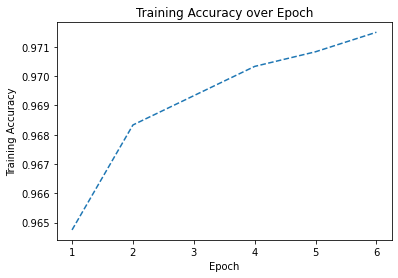

In [8]:
epochs = np.arange(1, len(train_accuracy_values)+1)

plt.figure()
plt.plot(epochs, train_accuracy_values, linestyle='--')
#plt.plot(epochs, val_accuracy_values, linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy over Epoch')
plt.savefig('vp_training_accuracy.png')
plt.show()

6. Provide the accuracy on the training and validation set, for the epoch on which you obtain your highest accuracy on the validation set.

In [9]:
epoch = np.argmax(val_accuracy_values)
print("Validation accuracy on epoch {} = {}".format(epoch+1, val_accuracy_values[epoch]))
print("Training accuracy on epoch {} = {}".format(epoch+1, train_accuracy_values[epoch]))

Validation accuracy on epoch 6 = 0.975
Training accuracy on epoch 6 = 0.9715
